In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from google.colab.patches import cv2_imshow
#from sklearn.model_selection import train_test_split
import IPython
#from __future__ import print_function
import os
import sys
#import tarfile
from IPython.display import display, Image
#import h5py
from PIL import Image
#import random
#from urllib.request import urlretrieve
#from collections import Counter
from skimage import segmentation
from skimage import io, color
import skimage

In [3]:
#https://buomsoo-kim.github.io/colab/2020/05/09/Colab-mounting-google-drive.md/
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#**Visualize Input Images**

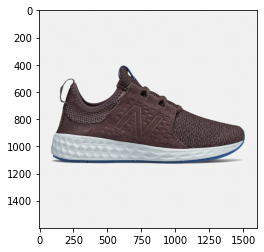

In [4]:
retail_path = '/content/drive/My Drive/504_project/Stitching/right.jpg'
retail = cv2.imread(retail_path)/255
plt.imshow(retail, cmap="gray")
plt.show()

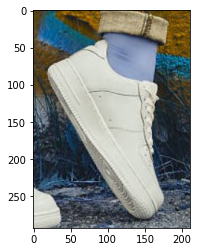

In [5]:
user_path = '/content/drive/My Drive/504_project/Stitching/user_right.JPG'
user = cv2.imread(user_path)/255
plt.imshow(user, cmap="gray")
plt.show()

#**Temporary Segmentation (from PS3), failed**



In [6]:
def label2rgb(labels):
  """
  Convert a labels image to an rgb image using a matplotlib colormap
  """
  label_range = np.linspace(0, 1, 256)
  lut = np.uint8(plt.cm.viridis(label_range)[:,2::-1]*256).reshape(256, 1, 3) # replace viridis with a matplotlib colormap of your choice
  return cv2.LUT(cv2.merge((labels, labels, labels)), lut)

In [7]:
def cluster_centers(superpixel_map):
  """ This function takes a superpixel map and returns a list with the 
  (row,col) positions of the cluster centers for that map"""

  x_centers = np.zeros(len(np.unique(superpixel_map)))
  y_centers = np.zeros_like(x_centers)
  counts = np.zeros_like(x_centers)
  rows, cols = superpixel_map.shape

  for row in range(rows):
    for col in range(cols):
      x_centers[superpixel_map[row, col]] += col
      y_centers[superpixel_map[row, col]] += row
      counts[superpixel_map[row, col]] += 1

  x_centers = np.round(x_centers/counts).astype('int')
  y_centers = np.round(y_centers/counts).astype('int')
  centers = list(zip(y_centers, x_centers))


  return centers

In [8]:
def apply_supermap(img, superpixel_map):
  """ This function returns an image where we assign the color of the cluster centers 
  to every pixel of their corresponding segmentation groups."""
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    out[superpixel_map == i] = img[row, col]
  return out


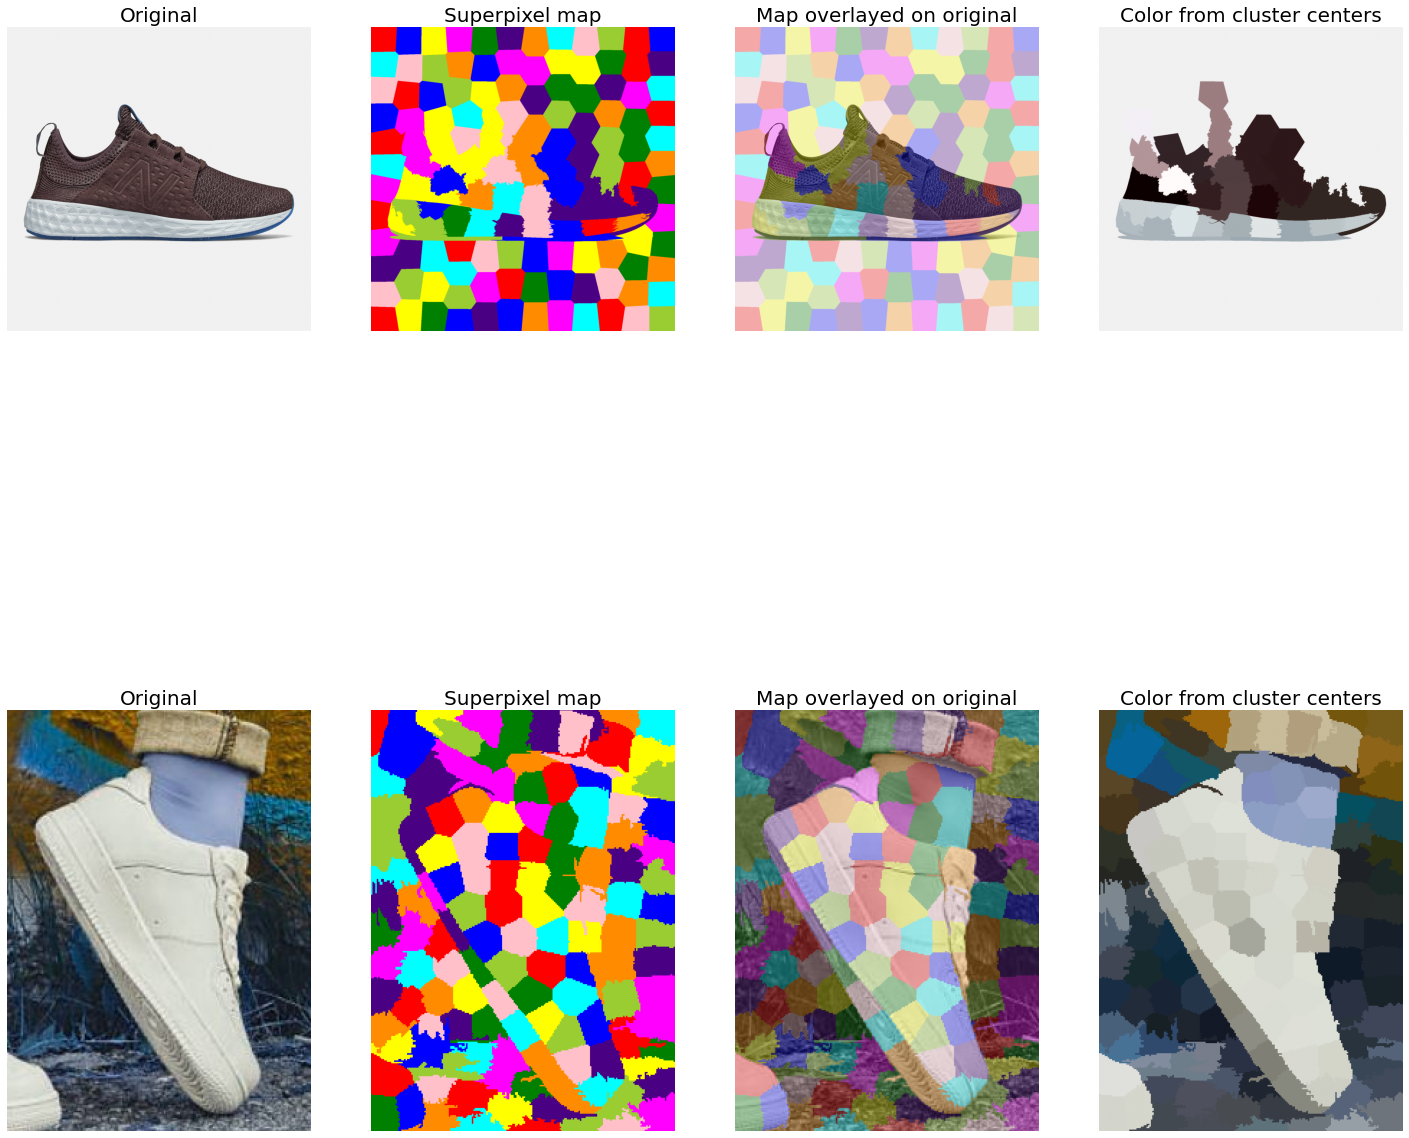

In [9]:
#Visualize superpixel map
super_retail = segmentation.slic(retail, n_segments=144, compactness=20, max_iter=20)
super_user = segmentation.slic(user, n_segments=144, compactness=20, max_iter=20)

fig, ax = plt.subplots(2, 4, figsize=(25,25))
images = [retail, user]
maps = [super_retail, super_user]

for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=20)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Superpixel map', fontsize=20)
  a[1].imshow(skimage.color.label2rgb(maps[i]))
  a[2].set_axis_off()
  a[2].set_title('Map overlayed on original', fontsize=20)
  a[2].imshow(skimage.color.label2rgb(maps[i], images[i]))
  a[3].set_axis_off()
  a[3].set_title('Color from cluster centers', fontsize=20)
  a[3].imshow(apply_supermap(images[i], maps[i]))



In [10]:
def color_histogram(img, mask, num_bins):
  """For each channel in the image, compute a color histogram with the number of bins
  given by num_bins (uniformly space bins in the range 0:1) of the pixels in 
  image where the mask is true. Then, concatenate the vectors together into one column vector (first
  channel at top).

  Mask is a matrix of booleans the same size as image.
 
  You MUST normalize the histogram of EACH CHANNEL so that it sums to 1.
  You CAN use the numpy.histogram function.
  You MAY loop over the channels.
  The output should be a 3*num_bins vector because we have a color image and 
  you have a separate histogram per color channel."""

  rows, cols, channels = img.shape
  histogram = np.zeros(num_bins*3)

  # ===============================================
  histogram = []
  masked = img[mask]
  for i in range(channels):
    h, _ = np.histogram(masked[:,i], bins=num_bins)
    h = h / np.sum(h)
    histogram.append(h)
  histogram = np.array(histogram)
  histogram = histogram.reshape(-1)

  # ===============================================

  return histogram

In [11]:
def adjacencyMatrix(superpixel_map):
  """Implement the code to compute the adjacency matrix for the superpixel map
  The input is a superpixel map and the output is a binary adjacency matrix NxN 
  (N being the number of superpixelsin svMap).  Bmap has a 1 in cell i,j if 
  superpixel i and j are neighbors. Otherwise, it has a 0.  Superpixels are neighbors 
  if any of their pixels are neighbors."""

  segmentList = np.unique(superpixel_map)
  segmentNum = len(segmentList)
  adjMatrix = np.zeros((segmentNum, segmentNum))

  # ===============================================
  row, col = superpixel_map.shape
  for i in range(row):
    for j in range(col):
      if i+1<row and superpixel_map[i,j] != superpixel_map[i+1,j]:
        r,c = superpixel_map[i,j], superpixel_map[i+1,j]
        adjMatrix[r,c] = 1
        adjMatrix[c,r] = 1
      if j+1<col and superpixel_map[i,j] != superpixel_map[i,j+1]:
        r,c = superpixel_map[i,j],  superpixel_map[i,j+1]
        adjMatrix[r,c] = 1
        adjMatrix[c,r] = 1
  # ===============================================

  return adjMatrix

In [12]:
# Python program for implementation of Ford Fulkerson algorithm 
# The author of this code is Neelam Yadav 

from collections import defaultdict 
   
#This class represents a directed graph using adjacency matrix representation 
class Graph: 
   
    def __init__(self,graph): 
        self.graph = graph # residual graph 
        self. ROW = len(graph) 
        # self.COL = len(gr[0]) 
          
   
    '''Returns true if there is a path from source 's' to sink 't' in 
    residual graph. Also fills parent[] to store the path '''
    def BFS(self,s, t, parent): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(self.ROW) 
          
        # Create a queue for BFS 
        queue=[] 
          
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
           
         # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
          
            # Get all adjacent vertices of the dequeued vertex u 
            # If a adjacent has not been visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting from source, then return 
        # true, else false 
        return True if visited[t] else False
              
      
    # Returns tne current flow from s to t in the given graph 
    def FordFulkerson(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.ROW) 
  
        max_flow = 0 # There is no flow initially 
        current_flow = np.zeros_like(self.graph)
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, parent) : 
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while(s !=  source): 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow +=  path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v !=  source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                current_flow[u][v] += path_flow 
                current_flow[v][u] -= path_flow 
                v = parent[v] 
        
        return current_flow
  

In [13]:
def reduce(img, superpixel_map, num_bins=10):
  """This function takes as input an image, its corresponding superpixel map, and a 
  number of bins as input. The output is a list of feature vectors. 
  Each feature vector is the resulting histogram from applying the color_histogram 
  function you implemented to every segment on the superpixel map."""

  feature_vectors = []
  num_segments = len(np.unique(superpixel_map))
  for i in range(num_segments):
      mask = superpixel_map == i
      feature_vectors.append(color_histogram(img, mask, num_bins))
  return(feature_vectors)

In [14]:
def graph_cut(superpixel_map, features, centers, keyindex):
  """Function to take a superpixel set and a keyindex and convert to a 
  foreground/background segmentation.
  
  keyindex is the index to the superpixel segment we wish to use as foreground and
  find its relevant neighbors.
  
  centers is a list of tuples (row, col) with the positions of the cluster centers 
  of the superpixel_map

  features is a list of histograms (obtained from the reduce function) for every superpixel
  segment in an image.
  
  """

  #Compute basic adjacency information of superpixels
  #Note that adjacencyMatrix is code you need to implement

  # ===============================================
  # TODO: this should be one line of code

  adjMatrix = adjacencyMatrix(superpixel_map)

  # ===============================================
  

  # normalization for distance calculation based on the image size
  # for points (x1,y1) and (x2,y2), distance is
  # exp(-||(x1,y1)-(x2,y2)||^2/dnorm)
  dnorm = 2*(superpixel_map.shape[0]/2 *superpixel_map.shape[1]/2)**2
  k = len(features) #number of superpixels in image

  #Generate capacity matrix
  capacity = np.zeros((k+2,k+2))
  source = k
  sink = k+1

  # This is a single planar graph with an extra source and sink
  #  Capacity of a present edge in the graph is to be defined as the product of
  #  1:  the histogram similarity between the two color histogram feature vectors.
  #  The similarity between histograms should be computed as the intersections between 
  #  the histograms. i.e: sum(min(histogram 1, histogram 2))
  #  2:  the spatial proximity between the two superpixels connected by the edge.
  #      use exp(-||(x1,y1)-(x2,y2)||^2/dnorm) 
  #      
  #  Source gets connected to every node except sink
  #  Capacity is with respect to the keyindex superpixel
  #  Sink gets connected to every node except source and its capacity is opposite 
  # The weight between a pixel and the sink is going to be the max of all the weights between 
  # the source and the image pixels minus the weight between that specific pixel and the source.
  # Other superpixels get connected to each other based on computed adjacency
  # matrix: the capacity is defined as above, EXCEPT THAT YOU ALSO NEED TO MULTIPLY BY A SCALAR 0.25 for
  # adjacent superpixels.


  key_features = features[keyindex] # color histogram representation of superpixel # keyindex
  key_x = centers[keyindex][1] # row of cluster center for superpixel # keyindex
  key_y =  centers[keyindex][0] # col of cluster center for superpixel # keyindex

  # ===============================================
  # TODO: Generate the capacity matrix using the description above. Replace pass with your code
  
  centers=np.array(centers)
  #capacity between nodes
  for i in range(k):
    for j in range(i+1, k):
      if adjMatrix[i][j] == 0: #no edge between superpixels
        continue
      cap = np.sum(np.min([features[i], features[j]], axis=0))
      cap *= np.exp(-1*np.linalg.norm(centers[i]-centers[j])**2/dnorm)
      cap *= 0.25
      capacity[i][j] = cap
      capacity[j][i] = cap
  
  first=True
  #source to nodes
  key_center = centers[keyindex]
  for i in range(k):
    cap = np.sum(np.min([features[i], key_features], axis=0))
    cap *= np.exp(-1*np.linalg.norm(centers[i]-key_center)**2/dnorm)
    capacity[source][i] = cap

  #nodes to sink
  max_source_cap = np.max(capacity[source, :])
  for i in range(k):
    capacity[i][sink] = max_source_cap - capacity[source][i]

  # ===============================================
      
  # Obtaining the current flow of the graph when the flow is max
  g = Graph(capacity.copy()) 
  current_flow = g.FordFulkerson(source, sink)
  
  # Extract the two-class segmentation.
  # the cut will separate all nodes into those connected to the
  # source and those connected to the sink.
  # The current_flow matrix contains the necessary information about
  # the max-flow through the graph.
 
  segment_map = np.zeros_like(superpixel_map)
  rem_capacity = capacity - current_flow

  # ===============================================
  # TODO: Do the segmentation and fill segmentation map with 1s where the foreground is.
  # Replace pass with your code
  
  #find nodes connected to source
  source_connected = set()
  stack = [source]
  while len(stack) > 0: #depth first tree search
    top = stack.pop()
    for i in range(k):
      if i not in source_connected and rem_capacity[top][i] > 0:
        source_connected.add(i)
        stack.append(i)
  #construct segmentation map
  for i in source_connected:
    segment_map[superpixel_map == i] = 1

  # ===============================================
  
  return capacity, segment_map

'\nax[1][0].set_title(\'User\', fontsize=20)\nax[1][0].imshow(user, cmap="gray")\nax[1][1].set_title(\'User: superpixel selected\', fontsize=20)\nax[1][1].imshow(super_user==user_center_point, cmap="gray")\nax[1][2].set_title(\'User: segmentation\', fontsize=20)\nax[1][2].imshow(user_segment_map, cmap="gray")\n'

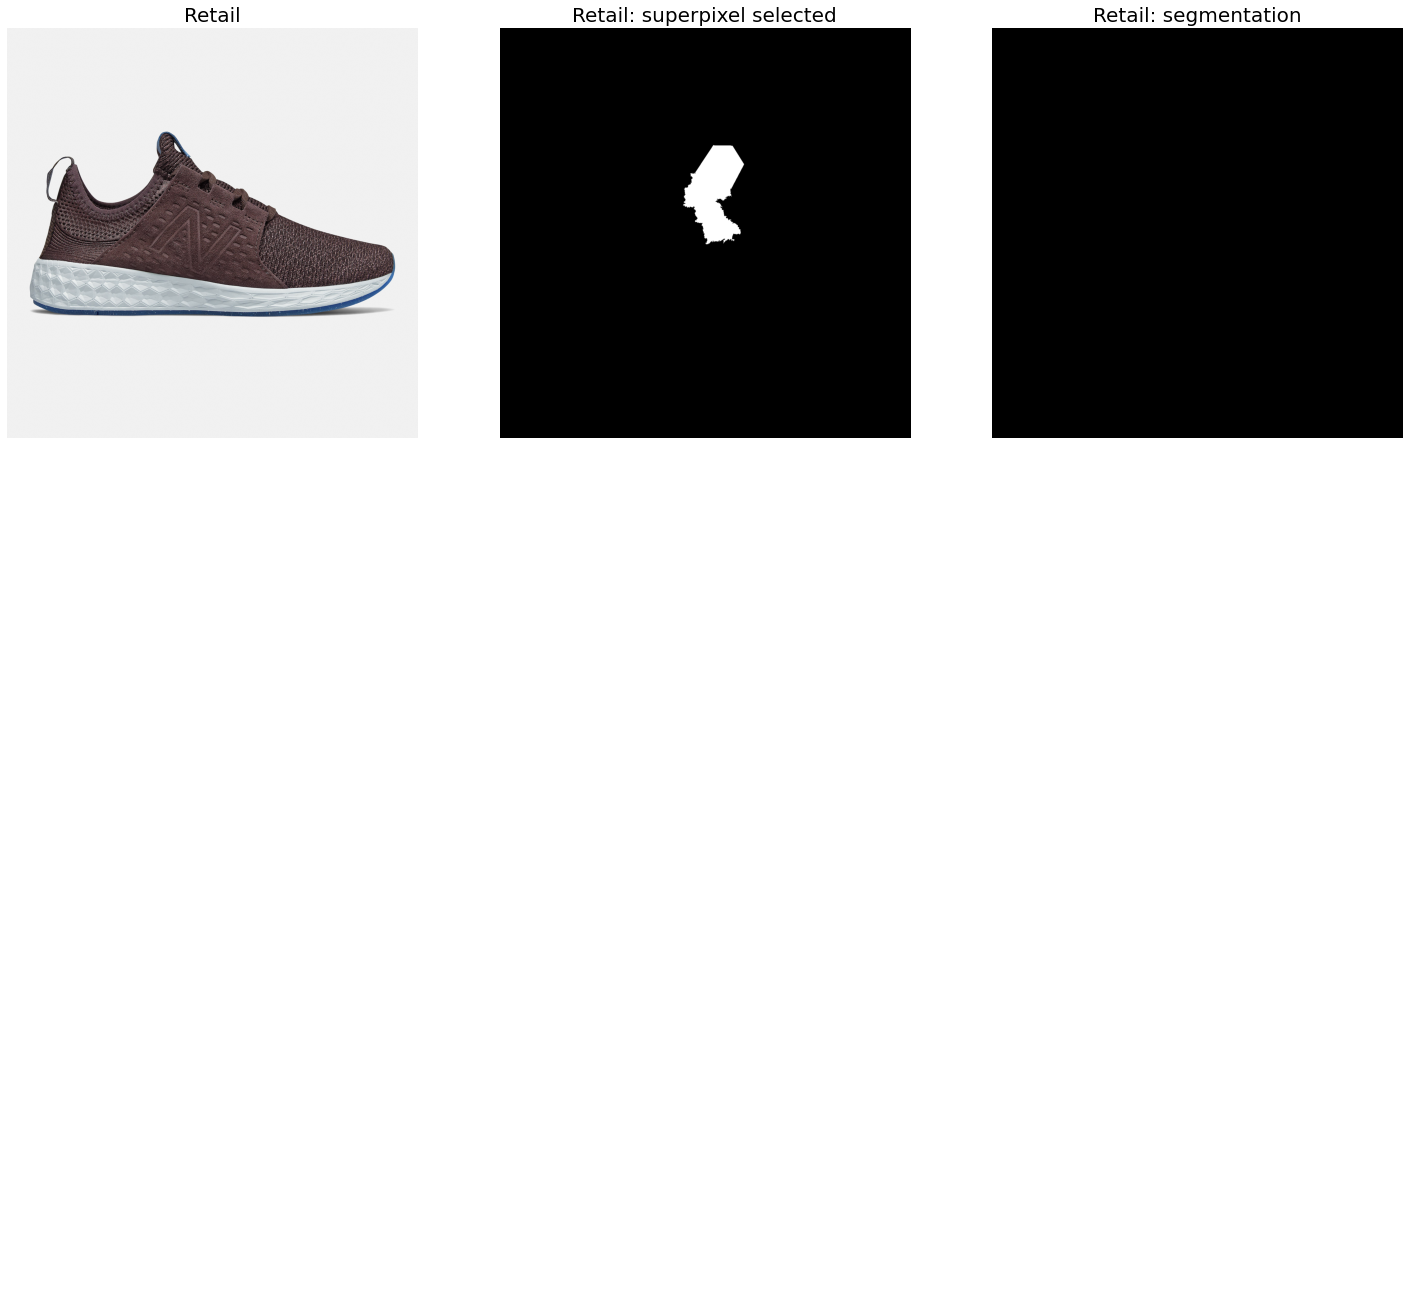

In [15]:
retail_x, retail_y, retail_c = retail.shape
retail_center_point = super_retail[retail_x//2, retail_y//2]
retail_features = reduce(retail, super_retail)
retail_centers = cluster_centers(super_retail)
retail_capacity, retail_segment_map = graph_cut(super_retail, retail_features, retail_centers, retail_center_point) #center is selected as foreground

"""
user_x, user_y, user_c = user.shape
user_center_point = super_user[user_x//2, user_y//2]
user_features = reduce(user, super_user)
user_centers = cluster_centers(super_user)
user_capacity, user_segment_map = graph_cut(super_user, user_features, user_centers, user_center_point) #center is selected as foreground
"""

fig, ax = plt.subplots(2, 3, figsize=(25,25))

for i in range(2):
  for j in range(3):
    ax[i][j].set_axis_off()

ax[0][0].set_title('Retail', fontsize=20)
ax[0][0].imshow(retail, cmap="gray")
ax[0][1].set_title('Retail: superpixel selected', fontsize=20)
ax[0][1].imshow(super_retail==retail_center_point, cmap="gray")
ax[0][2].set_title('Retail: segmentation', fontsize=20)
ax[0][2].imshow(retail_segment_map, cmap="gray")

"""
ax[1][0].set_title('User', fontsize=20)
ax[1][0].imshow(user, cmap="gray")
ax[1][1].set_title('User: superpixel selected', fontsize=20)
ax[1][1].imshow(super_user==user_center_point, cmap="gray")
ax[1][2].set_title('User: segmentation', fontsize=20)
ax[1][2].imshow(user_segment_map, cmap="gray")
"""

#**PCA orientation matching**

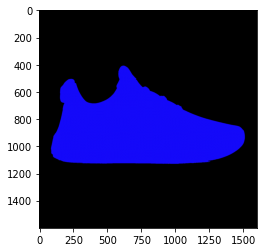

In [16]:
retail_path = '/content/drive/My Drive/504_project/Stitching/right_photoshoped_blue.jpg'
retail = plt.imread(retail_path)/255
plt.imshow(retail, cmap="gray")
plt.show()

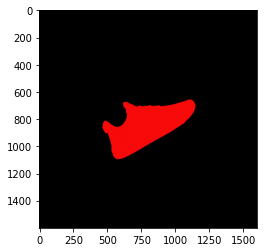

In [17]:
user_path = '/content/drive/My Drive/504_project/Stitching/right_photoshoped_red.jpg'
user = plt.imread(user_path)/255

#create user image by rotating 30 degree
rows, cols, c = user.shape
M = cv2.getRotationMatrix2D((rows/2,cols/2),30,0.5)
user = cv2.warpAffine(user, M, (rows, cols))
plt.imshow(user, cmap="gray")
plt.show()

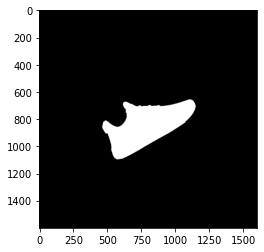

In [18]:
#user photo segmentation map
user_seg = user[:,:,0] != 0
plt.imshow(user_seg, cmap='gray')

In [19]:
def largest_eigvec(seg_map):
  #create 2 x N array
  X, Y = seg_map.nonzero()
  coords = np.zeros((2, len(X)))
  coords[0, :] = np.array(X)
  coords[1, :] = np.array(Y)
  avg = np.mean(coords, axis=1)
  coords = coords - avg.reshape(2, 1) #make it 0-mean

  u, s, vh = np.linalg.svd(coords, full_matrices=False)
  largest = np.argmax(s) #index of largest eigval
  largest_vec = u[largest, :] #largest eigval for covarianace matrix (row of U)

  return largest_vec

In [20]:
user_eigvec = largest_eigvec(user_seg)

#FINISH UPDATING CODE BELOW
#MAKE INTO FUNCTIONS (simply apply both to user and retail)

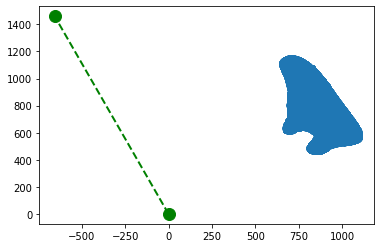

In [21]:
#visualize largest eigenvector
X, Y = user_seg.nonzero()
plt.scatter(X,Y)
plt.plot([user_eigvec[0], user_eigvec[0]*rows], [user_eigvec[1], user_eigvec[1]*cols], color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [22]:
def get_rotation_mat(eigvec, img):
  ax_vec = np.array([0,1])
  theta = np.arccos(np.dot(eigvec, ax_vec))
  rows, cols, c = img.shape
  direction = np.sign(eigvec[0])
  angle = direction*theta*180/np.pi
  user_M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
  return user_M, angle

In [23]:
def rotate_seg_map(seg_map, rot_M):
  rows, cols = seg_map.shape
  seg_temp = np.zeros((rows, cols, 3))
  for i in range(c):
    seg_temp[:,:,i] = seg_map #create temporary c channel segmentation map
  seg_map_oriented = cv2.warpAffine(seg_temp, rot_M, (rows, cols))[:,:,0] #rotate then remove duplciate
  return seg_map_oriented

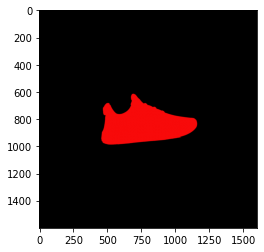

In [24]:
user_M, user_angle = get_rotation_mat(user_eigvec, user)

rows, cols, c = user.shape
user_oriented = cv2.warpAffine(user, user_M, (rows, cols))
user_seg_oriented = rotate_seg_map(user_seg, user_M)
plt.imshow(user_oriented, cmap="gray")
plt.show()

#**Orient retail shoe**

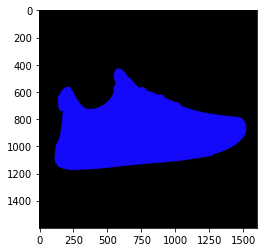

In [26]:
retail_seg = retail[:,:,0]

retail_eigvec = largest_eigvec(retail_seg)
retail_M, retail_angle = get_rotation_mat(retail_eigvec, retail)

rows, cols, c = retail.shape
retail_oriented = cv2.warpAffine(retail, retail_M, (rows, cols))
retail_seg_oriented = rotate_seg_map(retail_seg, retail_M)
plt.imshow(retail_oriented, cmap="gray")
plt.show()

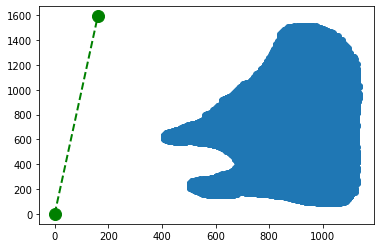

In [27]:
#visualize largest eigenvector
rows, cols, c = retail.shape
X, Y = retail_seg.nonzero()
plt.scatter(X,Y)
plt.plot([retail_eigvec[0], retail_eigvec[0]*rows], [retail_eigvec[1], retail_eigvec[1]*cols], color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [28]:
print(retail_eigvec, user_eigvec)

[0.10053844 0.99493317] [-0.40967398  0.912232  ]


#**Least Squares Matching**

In [ ]:
# X = rows, Y = cols
def find_left_right(oriented_seg_map):
  X, Y = oriented_seg_map.nonzero()
  leftmost = np.min(Y)
  rightmost = np.max(Y)
  return leftmost, rightmost

In [ ]:
# X = rows, Y = cols
def contour_slices(oriented_seg_map, num_slices = 10):
  leftmost, rightmost = find_left_right(oriented_seg_map)
  interval = (rightmost-leftmost)/(num_slices+1) #double
  X = np.zeros(num_slices*2)
  Y = np.zeros(num_slices*2)
  for i in range(num_slices):
    slice_pos = int(leftmost + interval*(i+1)) #integer value
    x_vals = oriented_seg_map[:, slice_pos].nonzero()
    Y[i*2:i*2+2] = slice_pos
    X[i*2] = np.min(x_vals) #lowest contour intersection
    X[i*2+1] = np.max(x_vals) #highest contour intersection
  return X, Y

In [ ]:
user_contour_X, user_contour_Y = contour_slices(user_seg_oriented)
retail_contour_X, retail_contour_Y = contour_slices(retail_seg_oriented)

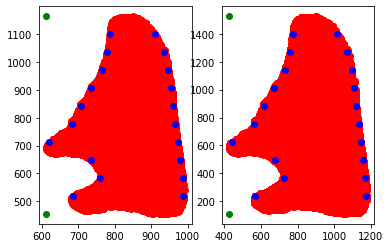

In [ ]:
#visualize user contour

fig, ax = plt.subplots(1, 2)

X, Y = user_seg_oriented.nonzero()
ax[0].scatter(X, Y, color='red')
ax[0].scatter(user_contour_X, user_contour_Y, color='blue')
leftmost, rightmost = find_left_right(user_seg_oriented)
ax[0].scatter([np.min(X),np.min(X)], [leftmost, rightmost], color='green')

X, Y = retail_seg_oriented.nonzero()
ax[1].scatter(X, Y, color='red')
ax[1].scatter(retail_contour_X, retail_contour_Y, color='blue')
leftmost, rightmost = find_left_right(retail_seg_oriented)
ax[1].scatter([np.min(X),np.min(X)], [leftmost, rightmost], color='green')


In [ ]:
#Least squares for retail --> user, min||Ax-b||^2
num_slices = len(retail_contour_X)
A = np.zeros((num_slices*2, 3))
b = np.zeros(num_slices*2)
for i in range(num_slices):
  x, y = retail_contour_X[i], retail_contour_Y[i]
  A[i*2, :] = np.array([x,1,0])
  A[i*2+1, :] = np.array([y,0,1])
  b[i*2] = user_contour_X[i]
  b[i*2+1] = user_contour_Y[i]

s, tx, ty = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T), b)
print(s, tx, ty)

0.5011020618083242 398.7730222069196 399.599615502599


In [ ]:
#https://www.kite.com/python/docs/cv2.estimateAffinePartial2D
src = np.vstack((retail_contour_X, retail_contour_Y)).T
dst = np.vstack((user_contour_X, user_contour_Y)).T
affine_m, _ = cv2.estimateAffinePartial2D(src, dst)
affine_m

array([[ 5.00987745e-01, -2.97412007e-04,  3.99256287e+02],
       [ 2.97412007e-04,  5.00987745e-01,  3.99409353e+02]])

0.03401370776305993 0.5177651133926583


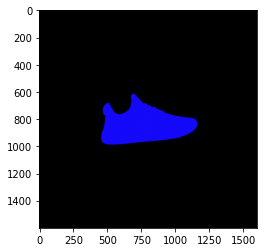

In [ ]:
scos = affine_m[0,0]
ssin = affine_m[1,0]

theta = np.arctan(ssin/scos)
angle = theta * 180 / np.pi
scale = np.sqrt(scos**2 + ssin **s)
print(angle, scale)

rows, cols, c = retail_oriented.shape
retail_transformed = cv2.warpAffine(retail_oriented, affine_m, (rows, cols))
retail_seg_transformed = rotate_seg_map(retail_oriented, retail_seg_oriented, affine_m)
plt.imshow(retail_transformed)

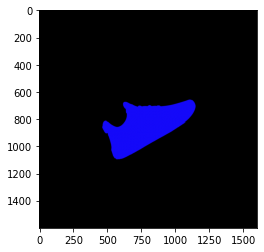

In [ ]:
#mask using user segmentation map (optional)

#rotate back to user's original orientation
rows, cols = retail_seg_oriented.shape
reverse_rot_M = cv2.getRotationMatrix2D((rows/2,cols/2),-user_angle, 1)
retail_complete = cv2.warpAffine(retail_transformed, reverse_rot_M, (rows,cols))
retail_seg_complete = rotate_seg_map(retail_seg_transformed, reverse_rot_M)
plt.imshow(retail_complete)

#TO DO: gotta account for size differene
#paste it back to user photo
_, _, c = user.shape
user_complete = user.copy()
for i in range(c):
  user_complete[:,:,i][retail_seg_complete] = retail_complete[:,:,i][retail_seg_compelte]

plt.imshow(user_complete)
